In [1]:
from dotenv import load_dotenv
import os

load_dotenv("config.env")

os.environ.get("OPENAI_API_KEY")
os.environ.get("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [2]:
from langchain_openai import ChatOpenAI
from llama_index.core import StorageContext, load_index_from_storage

# Load index for retrieval
storage_context = StorageContext.from_defaults(persist_dir="arv_metadata")
index = load_index_from_storage(storage_context)
retriever = index.as_retriever(similarity_top_k=5,
                                # Similarity threshold for filtering
                                similarity_threshold=0.5)

def rag_retrieve(user_prompt: str) -> str:
    """Perform RAG search of repository containing authoritative information on HIV/AIDS in Kenya.

    Args:
        user_prompt: The user's query.
    """
    sources = retriever.retrieve(user_prompt)
    retrieved_text = "\n\n".join([f"Source {i+1}: {source.text}" for i, source in enumerate(sources)])

    return "RAG search results for: " + retrieved_text

tools = [rag_retrieve]
# llm_lc = ChatOpenAI(temperature = 0.0, model="gpt-4o")
from langchain_ollama import ChatOllama
llm_lc = ChatOllama(model="llama3.2:1b")
llm_with_tools = llm_lc.bind_tools([rag_retrieve])

Loading llama_index.core.storage.kvstore.simple_kvstore from arv_metadata/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from arv_metadata/index_store.json.


In [3]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="""
                        You are a helpful assistant tasked with helping clinicians
                        access information from HIV clinical guidelines.
                        """
                        )

# Assistant Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


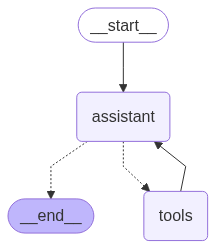

In [4]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Specify a thread
config = {"configurable": {"thread_id": "100"}}

messages = [HumanMessage(content="when should viral loads be taken?")]
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

when should viral loads be taken?
================================== Ai Message ==================================
Tool Calls:
  rag_retrieve (d52d2a7a-e00d-4cb7-afff-4183e6859985)
 Call ID: d52d2a7a-e00d-4cb7-afff-4183e6859985
  Args:
    user_prompt: When should viral loads be taken?
================================= Tool Message =================================
Name: rag_retrieve

RAG search results for: Source 1: discontinued  
HIV Viral Load   ● For PCR positive HEIs: baseline at the time of ART initiation  
● Age 0 -24 years: at month 3, then every 6 months  
● Age ≥ 25 years: at month 3, then month 12, then annually thereafter if 
suppressed  
● For all: before any drug substitution for patients on ART for a t least 6 
months with no valid VL, at month 3 after regimen modification, and 
then as per population group  
● Any patient with a detectable VL during routine monitoring, follow viral 
load 

In [26]:
# messages['messages'][3]
messages['messages'][len(messages['messages']) - 2].content

'what if the patient is pregnant and just found out they have HIV?'